In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Configuración ----------
start = "2015-01-01"
end   = "2025-09-25"  # último día que quieres incluir para estimar μ y Σ
np.random.seed(42)

# Tickers de la cartera conservadora (con BTC y menos bonos/commodities)
tickers = [
    "AAPL","MSFT","JPM","XOM","TSLA",
    "PG","NESN.SW","SAP.DE","SAN.MC","ASML.AS",
    "TLT","BND","IEF",
    "GLD","BTC-USD"
]

weights_cons = {
    "AAPL": 0.05, "MSFT": 0.10, "JPM": 0.10, "XOM": 0.00, "TSLA": 0.05,
    "PG": 0.10, "NESN.SW": 0.10, "SAP.DE": 0.05, "SAN.MC": 0.05, "ASML.AS": 0.00,
    "TLT": 0.05, "BND": 0.10, "IEF": 0.10,
    "GLD": 0.10, "BTC-USD": 0.05
}

# ---------- Descarga: Close ajustado, formato plano ----------
data = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)
prices = data["Close"].copy()
prices.columns.name = None
prices = prices.dropna(how="all")
prices.head()

,AAPL,ASML.AS,BND,BTC-USD,GLD,IEF,JPM,MSFT,NESN.SW,PG,SAN.MC,SAP.DE,TLT,TSLA,XOM
Date,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,314.248993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,24.261055,80.138603,61.176273,315.032013,114.080002,84.979919,46.948078,39.933060,NaN,66.983498,4.386594,49.391418,96.147354,14.620667,58.423485
2015-01-03,NaN,NaN,NaN,281.082001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,264.195007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,23.577572,78.664032,61.353909,274.473999,115.800003,85.498436,45.490574,39.565853,52.372536,66.665024,4.186324,47.763691,97.657646,14.006000,56.824905


In [2]:
# Log-retornos diarios por activo
logret = np.log(prices / prices.shift(1)).dropna(how="any")

# Alinear pesos a los activos realmente descargados (por si faltara alguno)
w = pd.Series({k: v for k, v in weights_cons.items() if k in logret.columns}, dtype=float)
w = w / w.sum()  # normaliza por si faltó algún ticker
logret = logret[w.index]  # reordena columnas como en w

# Estimadores diarios
mu_vec = logret.mean().values           # vector μ (n,)
cov_mat = logret.cov().values           # matriz Σ (n x n)
n_assets = len(w)
n_assets, w.sum(), logret.shape

(15, np.float64(1.0), (2019, 15))

In [3]:
# Parámetros de simulación
n_days = 252      # 1 año bursátil
n_sims = 10000    # nº de escenarios
V0 = 1.0          # riqueza inicial normalizada (1 = 100%)

# Simulación de log-retornos correlacionados ~ N(μ, Σ)
# shape: (n_days, n_sims, n_assets)
logret_sims = np.random.multivariate_normal(mean=mu_vec, cov=cov_mat, size=(n_days, n_sims))

# Pasar a retornos simples por activo: exp(logret) - 1
ret_sims = np.exp(logret_sims) - 1.0    # (n_days, n_sims, n_assets)

# Agregar por pesos a retorno de cartera (por día y simulación)
w_vec = w.values.reshape(1, 1, -1)                      # shape (1,1,n_assets)
ret_port = (ret_sims * w_vec).sum(axis=2)               # (n_days, n_sims)

# Trayectorias de riqueza de la cartera
wealth = V0 * np.cumprod(1.0 + ret_port, axis=0)        # (n_days, n_sims)

wealth.shape

(252, 10000)

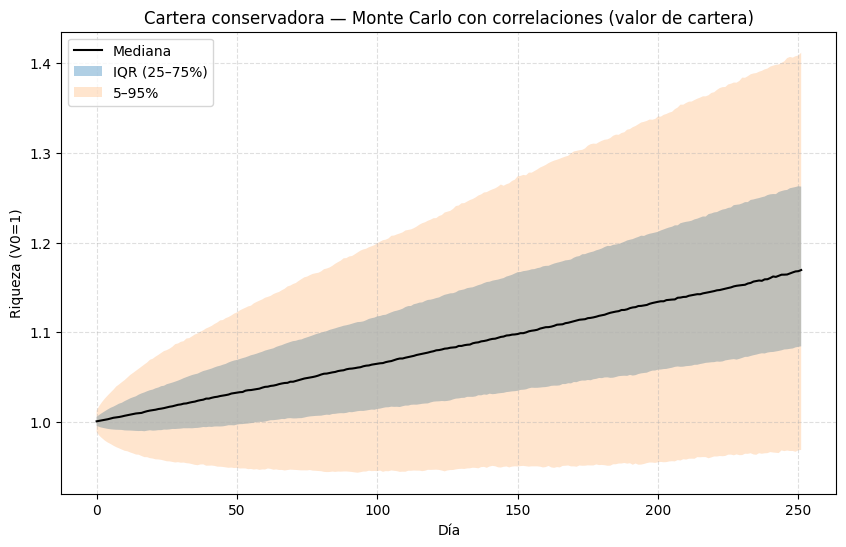

In [4]:
# Percentiles diarios del valor de cartera
p5  = np.percentile(wealth, 5,  axis=1)
p25 = np.percentile(wealth, 25, axis=1)
p50 = np.percentile(wealth, 50, axis=1)
p75 = np.percentile(wealth, 75, axis=1)
p95 = np.percentile(wealth, 95, axis=1)

plt.figure(figsize=(10,6))
plt.plot(p50, color="black", label="Mediana")
plt.fill_between(range(n_days), p25, p75, alpha=0.35, label="IQR (25–75%)")
plt.fill_between(range(n_days), p5,  p95, alpha=0.20, label="5–95%")
plt.title("Cartera conservadora — Monte Carlo con correlaciones (valor de cartera)")
plt.xlabel("Día")
plt.ylabel("Riqueza (V0=1)")
plt.legend()
plt.grid(True, ls="--", alpha=0.4)
plt.show()

RETORNO 1 año — P5: -3.12% | Mediana: 16.94% | P95: 41.17%
P(Perder >5%):  3.5%   |  P(Perder >10%): 1.2%
P(Ganar  >10%): 70.6%  |  P(Ganar  >20%): 40.5%
VaR95 (1y):  -3.12%
CVaR95 (1y): -7.80%


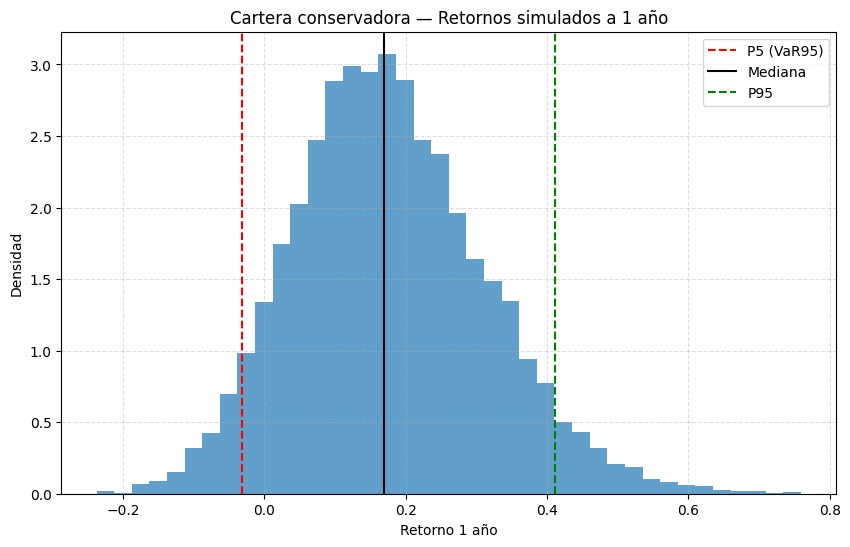

In [5]:
# Retorno total a 1 año (terminal): V_T / V0 - 1
terminal_returns = wealth[-1, :] - 1.0

# Percentiles de retorno 1 año
R_p5, R_med, R_p95 = np.percentile(terminal_returns, [5, 50, 95])

# Probabilidades útiles
prob_loss_5  = (terminal_returns < -0.05).mean()    # perder >5%
prob_loss_10 = (terminal_returns < -0.10).mean()    # perder >10%
prob_gain_10 = (terminal_returns >  0.10).mean()    # ganar >10%
prob_gain_20 = (terminal_returns >  0.20).mean()    # ganar >20%

# VaR/CVaR 1 año (95%)
var1y_95  = np.percentile(terminal_returns, 5)
cvar1y_95 = terminal_returns[terminal_returns <= var1y_95].mean()

print(f"RETORNO 1 año — P5: {R_p5:.2%} | Mediana: {R_med:.2%} | P95: {R_p95:.2%}")
print(f"P(Perder >5%):  {prob_loss_5:.1%}   |  P(Perder >10%): {prob_loss_10:.1%}")
print(f"P(Ganar  >10%): {prob_gain_10:.1%}  |  P(Ganar  >20%): {prob_gain_20:.1%}")
print(f"VaR95 (1y):  {var1y_95:.2%}")
print(f"CVaR95 (1y): {cvar1y_95:.2%}")

# Histograma de retornos a 1 año de la cartera
plt.figure(figsize=(10,6))
plt.hist(terminal_returns, bins=40, density=True, alpha=0.7)
plt.axvline(R_p5,  color="red",   ls="--", label="P5 (VaR95)")
plt.axvline(R_med, color="black", ls="-",  label="Mediana")
plt.axvline(R_p95, color="green", ls="--", label="P95")
plt.title("Cartera conservadora — Retornos simulados a 1 año")
plt.xlabel("Retorno 1 año")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True, ls="--", alpha=0.4)
plt.show()

In [6]:
#MONTE CARLO COMPLEJO CON CARTERA AGRESIVA#
# ---------- Pesos de la cartera agresiva ----------
weights_aggr = {
    "AAPL": 0.22, "MSFT": 0.15, "JPM": 0.00, "XOM": 0.05, "TSLA": 0.20,
    "PG": 0.05, "NESN.SW": 0.025, "SAP.DE": 0.05, "SAN.MC": 0.05, "ASML.AS": 0.15,
    "TLT": 0.00, "BND": 0.025, "IEF": 0.025,
    "GLD": 0.025, "BTC-USD": 0.05
}

# Alinear con columnas de logret ya calculado antes
w_aggr = pd.Series({k: v for k, v in weights_aggr.items() if k in logret.columns}, dtype=float)
w_aggr = w_aggr / w_aggr.sum()  # normalizamos por si algún ticker falta
logret_aggr = logret[w_aggr.index]

# Vector μ y Σ de esta cartera
mu_vec_a = logret_aggr.mean().values
cov_mat_a = logret_aggr.cov().values

In [7]:
# Parámetros de simulación
n_days = 252
n_sims = 10000
V0 = 1.0

# Simulación de retornos log multivariantes
logret_sims_a = np.random.multivariate_normal(mean=mu_vec_a, cov=cov_mat_a, size=(n_days, n_sims))

# Convertir a retornos simples
ret_sims_a = np.exp(logret_sims_a) - 1.0

# Agregar a cartera con pesos
w_vec_a = w_aggr.values.reshape(1,1,-1)
ret_port_a = (ret_sims_a * w_vec_a).sum(axis=2)

# Trayectorias de riqueza
wealth_a = V0 * np.cumprod(1.0 + ret_port_a, axis=0)

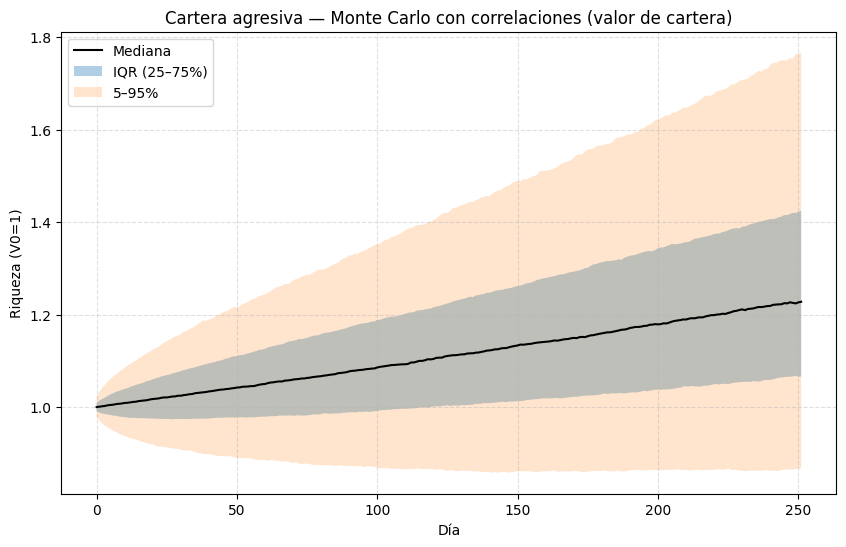

In [8]:
p5a  = np.percentile(wealth_a, 5,  axis=1)
p25a = np.percentile(wealth_a, 25, axis=1)
p50a = np.percentile(wealth_a, 50, axis=1)
p75a = np.percentile(wealth_a, 75, axis=1)
p95a = np.percentile(wealth_a, 95, axis=1)

plt.figure(figsize=(10,6))
plt.plot(p50a, color="black", label="Mediana")
plt.fill_between(range(n_days), p25a, p75a, alpha=0.35, label="IQR (25–75%)")
plt.fill_between(range(n_days), p5a,  p95a, alpha=0.20, label="5–95%")
plt.title("Cartera agresiva — Monte Carlo con correlaciones (valor de cartera)")
plt.xlabel("Día")
plt.ylabel("Riqueza (V0=1)")
plt.legend()
plt.grid(True, ls="--", alpha=0.4)
plt.show()

RETORNO 1 año — P5: -13.15% | Mediana: 22.82% | P95: 76.66%
P(Perder >5%):  10.8%   |  P(Perder >10%): 6.9%
P(Ganar  >10%): 70.2%  |  P(Ganar  >20%): 54.6%
VaR95 (1y):  -13.15%
CVaR95 (1y): -20.24%


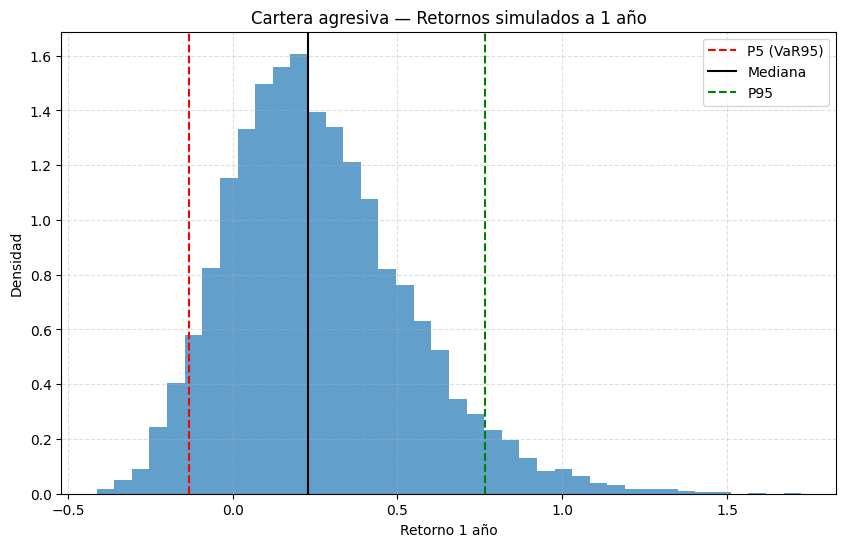

In [9]:
# Retornos a 1 año (terminal)
terminal_returns_a = wealth_a[-1, :] - 1.0

# Percentiles
R_p5_a, R_med_a, R_p95_a = np.percentile(terminal_returns_a, [5, 50, 95])

# Probabilidades
prob_loss_5_a  = (terminal_returns_a < -0.05).mean()
prob_loss_10_a = (terminal_returns_a < -0.10).mean()
prob_gain_10_a = (terminal_returns_a >  0.10).mean()
prob_gain_20_a = (terminal_returns_a >  0.20).mean()

# VaR y CVaR
var1y_95_a  = np.percentile(terminal_returns_a, 5)
cvar1y_95_a = terminal_returns_a[terminal_returns_a <= var1y_95_a].mean()

print(f"RETORNO 1 año — P5: {R_p5_a:.2%} | Mediana: {R_med_a:.2%} | P95: {R_p95_a:.2%}")
print(f"P(Perder >5%):  {prob_loss_5_a:.1%}   |  P(Perder >10%): {prob_loss_10_a:.1%}")
print(f"P(Ganar  >10%): {prob_gain_10_a:.1%}  |  P(Ganar  >20%): {prob_gain_20_a:.1%}")
print(f"VaR95 (1y):  {var1y_95_a:.2%}")
print(f"CVaR95 (1y): {cvar1y_95_a:.2%}")

# Histograma
plt.figure(figsize=(10,6))
plt.hist(terminal_returns_a, bins=40, density=True, alpha=0.7)
plt.axvline(R_p5_a,  color="red",   ls="--", label="P5 (VaR95)")
plt.axvline(R_med_a, color="black", ls="-",  label="Mediana")
plt.axvline(R_p95_a, color="green", ls="--", label="P95")
plt.title("Cartera agresiva — Retornos simulados a 1 año")
plt.xlabel("Retorno 1 año")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True, ls="--", alpha=0.4)
plt.show()

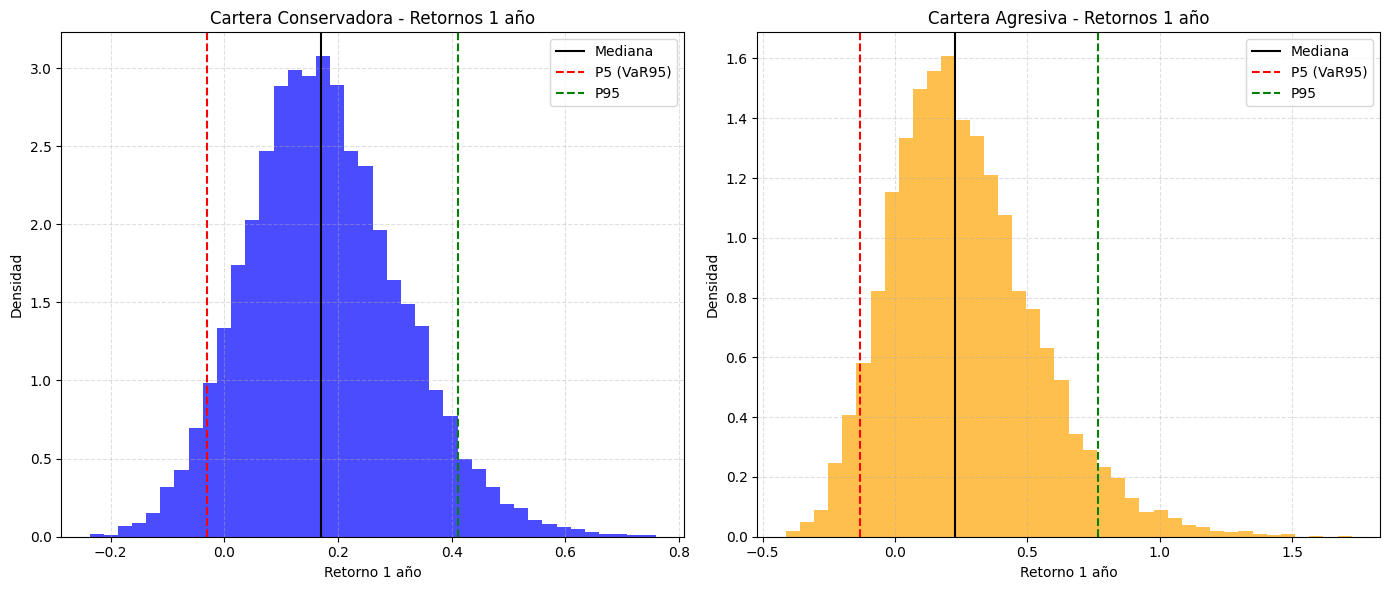

In [10]:
plt.figure(figsize=(14,6))

# Conservadora
plt.subplot(1,2,1)
plt.hist(terminal_returns, bins=40, density=True, alpha=0.7, color="blue")
plt.axvline(R_med, color="black", ls="-", label="Mediana")
plt.axvline(R_p5,  color="red",   ls="--", label="P5 (VaR95)")
plt.axvline(R_p95, color="green", ls="--", label="P95")
plt.title("Cartera Conservadora - Retornos 1 año")
plt.xlabel("Retorno 1 año")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True, ls="--", alpha=0.4)

# Agresiva
plt.subplot(1,2,2)
plt.hist(terminal_returns_a, bins=40, density=True, alpha=0.7, color="orange")
plt.axvline(R_med_a, color="black", ls="-", label="Mediana")
plt.axvline(R_p5_a,  color="red",   ls="--", label="P5 (VaR95)")
plt.axvline(R_p95_a, color="green", ls="--", label="P95")
plt.title("Cartera Agresiva - Retornos 1 año")
plt.xlabel("Retorno 1 año")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True, ls="--", alpha=0.4)

plt.tight_layout()
plt.show()

In [11]:
# --- Crear DataFrame comparativo ---
summary = pd.DataFrame({
    "Conservadora": {
        "P5": R_p5, "Mediana": R_med, "P95": R_p95,
        "P(Perder >5%)": prob_loss_5, "P(Perder >10%)": prob_loss_10,
        "P(Ganar >10%)": prob_gain_10, "P(Ganar >20%)": prob_gain_20,
        "VaR95": var1y_95, "CVaR95": cvar1y_95
    },
    "Agresiva": {
        "P5": R_p5_a, "Mediana": R_med_a, "P95": R_p95_a,
        "P(Perder >5%)": prob_loss_5_a, "P(Perder >10%)": prob_loss_10_a,
        "P(Ganar >10%)": prob_gain_10_a, "P(Ganar >20%)": prob_gain_20_a,
        "VaR95": var1y_95_a, "CVaR95": cvar1y_95_a
    }
}).T  # Transpuesta para ver como filas

# Formateo en %
summary_fmt = summary.applymap(lambda x: f"{x:.2%}")

summary_fmt

C:\Users\adrip\AppData\Local\Temp\ipykernel_9300\1580216046.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_fmt = summary.applymap(lambda x: f"{x:.2%}")


,P5,Mediana,P95,P(Perder >5%),P(Perder >10%),P(Ganar >10%),P(Ganar >20%),VaR95,CVaR95
Conservadora,-3.12%,16.94%,41.17%,3.48%,1.24%,70.59%,40.47%,-3.12%,-7.80%
Agresiva,-13.15%,22.82%,76.66%,10.84%,6.89%,70.22%,54.57%,-13.15%,-20.24%


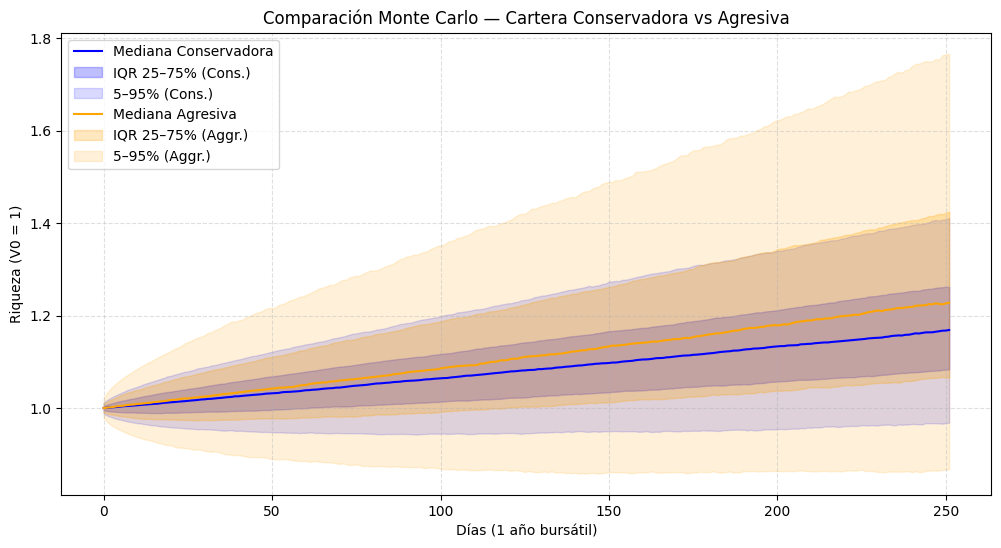

In [12]:
# Percentiles conservadora
p5_c  = np.percentile(wealth, 5,  axis=1)
p25_c = np.percentile(wealth, 25, axis=1)
p50_c = np.percentile(wealth, 50, axis=1)
p75_c = np.percentile(wealth, 75, axis=1)
p95_c = np.percentile(wealth, 95, axis=1)

# Percentiles agresiva
p5_a  = np.percentile(wealth_a, 5,  axis=1)
p25_a = np.percentile(wealth_a, 25, axis=1)
p50_a = np.percentile(wealth_a, 50, axis=1)
p75_a = np.percentile(wealth_a, 75, axis=1)
p95_a = np.percentile(wealth_a, 95, axis=1)

# --- Gráfico ---
plt.figure(figsize=(12,6))

# Conservadora (azul)
plt.plot(p50_c, color="blue", label="Mediana Conservadora")
plt.fill_between(range(n_days), p25_c, p75_c, color="blue", alpha=0.25, label="IQR 25–75% (Cons.)")
plt.fill_between(range(n_days), p5_c,  p95_c, color="blue", alpha=0.15, label="5–95% (Cons.)")

# Agresiva (naranja)
plt.plot(p50_a, color="orange", label="Mediana Agresiva")
plt.fill_between(range(n_days), p25_a, p75_a, color="orange", alpha=0.25, label="IQR 25–75% (Aggr.)")
plt.fill_between(range(n_days), p5_a,  p95_a, color="orange", alpha=0.15, label="5–95% (Aggr.)")

plt.title("Comparación Monte Carlo — Cartera Conservadora vs Agresiva")
plt.xlabel("Días (1 año bursátil)")
plt.ylabel("Riqueza (V0 = 1)")
plt.legend(loc="upper left")
plt.grid(True, ls="--", alpha=0.4)
plt.show()